<a href="https://colab.research.google.com/github/GeremiaPompei/P2P/blob/main/P2P_midterm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P2P & Blockchain [Midterm 1] - Pompei Geremia (MAT. 638432)

## First Part - Analysis of Bitcoin Transactions

### Code initialization

In [ ]:
!rm -rf midterm1
!wget -O midterm1.zip https://github.com/GeremiaPompei/P2P/blob/main/midterm1.zip?raw=true
!unzip midterm1.zip
!rm -rf midterm1.zip

import matplotlib.pyplot as plt
import networkx as nx

### 1) Describe how a real Bitcoin transaction is abstracted by a transaction in the dataset (which fields are eliminated, which are abstracted and how)

Fields abstracted:

  - **hash**: transaction hash in our dataset is represented by transaction id
  - **in**: array containing the input transactions represented by:
    - **prev_out**: json with 2 fields that are **hash** of the previous transaction and the **n** number of the output used here as input (in this dataset this field is abstracted by the field *outpud_id*)
    - **sigSig**: signature used to spend the output of previous transaction (in this dataset we have only an integer id corresponding to the address. This is the same of the corresponding *pk_id*)
  - **out**: array containing the output transactions represented by:
    - **value**: value that is transferred in output (not abstracted)
    - **scriptPubKey**: contains the address where previous value is transferred (in this dataset we have only an integer id corresponding to the address. This is the same of the corresponding *sig_id*)
  
  Here inputs and outputs are represented in another csv file and we are able to link them with the corresponding transaction using ids.

Fields eliminated:
- **ver**: version of bitcoin protocol
- **vin_sz**: number of input transaction
- **vout_sz**: number of output transaction
- **lock_time**: earliest time that a transaction can be added to the blockchain (0 signify immediate execution). This represents the period of time before that this transaction is added inside the blockchain

### 2) Check if all the data contained in the dataset is consistent, and if some data is invalid, describe what is the problem of that data and remove it from the dataset

Here all the files that represents the dataset are imported and are transformed in a more structured way

In [2]:
def extract_dict_from_csv(path, keys):
    text = open(f"midterm1/{path}.csv", "r").read()
    res = {}
    for row in text.split("\n"):
        tokens = row.split(",")
        if len(tokens) > 1:
            obj = dict([(keys[i], int(tokens[i])) for i in range(len(keys))])
            res[obj[keys[0]]] = obj
    return res

inputs = extract_dict_from_csv("inputs", ["id", "tx_id", "sig_id", "output_id"])
outputs = extract_dict_from_csv("outputs", ["id", "tx_id", "pk_id", "value"])
txs = extract_dict_from_csv("transactions", ["id", "block_id"])

#### 1. Check id relation consistency
Each input with a *tx_id* not in the transaction list and each output with a *tx_id* not in the transaction list are discarded

In [3]:
tx_to_delete = []

for key, i in list(inputs.items()):
  if i["tx_id"] not in txs:
    print(i)
    del inputs[key]

for key, o in list(outputs.items()):
  if o["tx_id"] not in txs:
    print(o)
    del outputs[key]
    tx_to_delete.append(o["tx_id"])

#### 2. Input-output relation consistency
With the following code each input with *output_id* not in the output list is discarded

In [4]:
for key, i in list(inputs.items()):
  if i["output_id"] != -1 and i["output_id"] not in outputs:
    print(i)
    del inputs[key]
    tx_to_delete.append(i["tx_id"])

{'id': 16461, 'tx_id': 15698, 'sig_id': 109902, 'output_id': 265834}


#### 3. Check signature consistency
Each input with invalid signature (in this case *sig_id* different from *pk_id*) is discarded. *pk_id* and *sk_id* should be equal or both non-standard (less than 0)

In [5]:
for key, i in list(inputs.items()):
  if i["output_id"] != -1:
    sig_id = i["sig_id"]
    pk_id = outputs[i["output_id"]]["pk_id"]
    if (sig_id > 0 and pk_id > 0 and pk_id != sig_id) or (sig_id < 0 and pk_id < 0):
      print(i, "=> ", sig_id, "!=", pk_id)
      del inputs[key]
      tx_to_delete.append(i["tx_id"])

{'id': 194075, 'tx_id': 138278, 'sig_id': 139250, 'output_id': 16121} =>  139250 != 16020


#### 4. Check if all values are positive
Check if the output value is positive for each transaction

In [6]:
for key, o in list(outputs.items()):
  if o["value"] < 0:
    print(o)
    del outputs[key]
    tx_to_delete.append(i["tx_id"])

{'id': 123672, 'tx_id': 105281, 'pk_id': 155098, 'value': -5000000000}


#### 5. Check double spending
If there are more than one input used to spend a transaction from the same output there is an episode of double speding. With the following lines of code are detected all the double spending and fixed


In [7]:
single_output = set()

for i in list(inputs.values()):
    if i["output_id"] != -1:
        if i["output_id"] in single_output:
            print(outputs[i["output_id"]])
            del inputs[i["id"]]
            tx_to_delete.append(i["tx_id"])
        single_output.add(i["output_id"])

{'id': 7998, 'tx_id': 7971, 'pk_id': 7941, 'value': 5000000000}
{'id': 21928, 'tx_id': 21878, 'pk_id': 21807, 'value': 5000000000}
{'id': 65403, 'tx_id': 61842, 'pk_id': 138980, 'value': 5000000000}
{'id': 249860, 'tx_id': 207362, 'pk_id': 163625, 'value': 41381000000}


#### Formatting and deletion

Now inputs and outputs are included their own transaction dictionaries and outputs include a pointer to their own input ids. It's also added the fee attribute inside each transaction

In [8]:
for i in inputs.values():
  if i["output_id"] > -1:
    outputs[i["output_id"]]["input_id"] = i["id"]
for o in outputs.values():
  if "input_id" not in o:
    o["input_id"] = -1

for tx in txs.values():
  tx["in"] = []
  tx["out"] = []

for i in inputs.values():
  if i["tx_id"] in txs:
    txs[i["tx_id"]]["in"].append(i)

for o in outputs.values():
  if o["tx_id"] in txs:
    txs[o["tx_id"]]["out"].append(o)

for tx in txs.values():
  fee = 0
  if len(list(filter(lambda x: x["output_id"] == -1, tx["in"]))) == 0:
    for i in tx["in"]:
      fee += outputs[i["output_id"]]["value"]
    for o in tx["out"]:
      fee -= o["value"]
    tx["fee"] = fee

The following lines are able to clean the dataset removing all inconsistent data

In [9]:
def delete_tx_in(tx_id):
  if tx_id in txs:
    tx = txs[tx_id]
    for i in tx["in"]:
      if i["output_id"] in outputs:
        delete_tx_in(outputs[i["output_id"]]["tx_id"])
      del inputs[i["id"]]
    del txs[tx["id"]]

def delete_tx_out(tx_id):
  if tx_id in txs:
    tx = txs[tx_id]
    for o in tx["out"]:
      if o["input_id"] in inputs:
        delete_tx_out(inputs[o["input_id"]]["tx_id"])
      del outputs[o["id"]]
    del txs[tx["id"]]

def delete_tx(tx_id):
  delete_tx_in(tx_id)
  delete_tx_out(tx_id)

for tx_id in tx_to_delete:
  delete_tx(tx_id);
tx_to_delete = []

### 3) Compute the total amount of UTXOs (Unspent Transaction Outputs) existing as of the last block of the data set, i.e. the sum of all the Transaction outputs balances on the UTXO set of the last block. Which UTXO (TxId, blockId, output index and address) has the highest asso- ciated value?

In the following code the output of each transaction is scanned to take the one that is not spent and has the highest value. Then is returned a dictionary that reports info related to:
- TxId: id of the transaction where there is the selected output
- blockId: id of the block, stored in the blockchain, where the transaction is
- output_index: id of the output of the transaction used to send the amount
- address: address of the account that can provide the signature to spend the value inside this transaction output

In [10]:
UTXO = None
max_value = 0

txs_values = list(txs.values())
txs_values.reverse()

output_spent = set({i["output_id"] for i in inputs.values() if i["output_id"] > 0})

for tx in txs_values:
  for o in tx["out"]:
    if o["id"] not in output_spent:
      if o["value"] > max_value:
        max_value = o["value"]
        UTXO = {
          "TxId": tx["id"],
          "blockId": tx["block_id"],
          "output_index": o["id"],
          "account": o["pk_id"],
        }

print(UTXO, "=>", max_value)

{'TxId': 140479, 'blockId': 90532, 'output_index': 170430, 'account': 138895} => 9000000000000


### 4) Compute the following statistics
1. the distribution of the block occupancy, i.e. of the number of transactions in each block in the entire period of time. Furthermore, show the evolution in time of the block size, by considering a time step of one month.
2. the total amount of bitcoin received from each public key that has received at least one COINBASE transaction, in the considered period, and show a distribution of the values
3. the distribution of the fees spent in each transaction in the considered period.

With the following code is built a dictionary that simulates the blockchain structure. Each item is a link between "block_id" and the list of transactions contained in this block

In [11]:
blockchain = {}
for tx in txs.values():
  if tx["block_id"] in blockchain:
    blockchain[tx["block_id"]].append(tx)
  else:
    blockchain[tx["block_id"]] = [tx]

Here the month labels are setted

In [12]:
months = (
    "Gen-2009", "Feb-2009", "Mar-2009", "Apr-2009", "May-2009", "Jun-2009", 
    "Jul-2009", "Ago-2009", "Sep-2009", "Oct-2009", "Nov-2009", "Dec-2009", 
    "Gen-2010", "Feb-2010", "Mar-2010", "Apr-2010", "May-2010", "Jun-2010", 
    "Jul-2010", "Ago-2010","Sep-2010", "Oct-2010", "Nov-2010", "Dec-2010", 
)

1 - Now all the block sizes for each block are taken and is computed the mean of the block sizes in a month for each month. In the end is shown the plot with the ditribution of averages of block sizes in 24 months

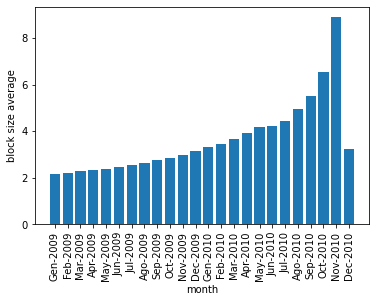

In [13]:
cs = len(blockchain) // len(months)
block_sizes = [len(block) for block in blockchain.values()]

c_block_sizes = []
for i in range(len(months)):
  blocks_one_month = block_sizes[i*cs:(i+cs)*cs-1]
  average = sum(blocks_one_month) / len(blocks_one_month)
  c_block_sizes.append(average)

plt.bar(months, c_block_sizes, align='center')
plt.xlabel('month')
plt.ylabel('block size average')
plt.xticks(rotation='vertical')
plt.show()

2 - After collecting all ids related to outputs of coinbase transactions it is taken all transactions (in each block of blockchain) with in input one coinbase transaction. Then it is computed the sum of the miner reward for each block and it is calculated the mean of values gained by miners in one month for each month. In the end everything is shown in a plot

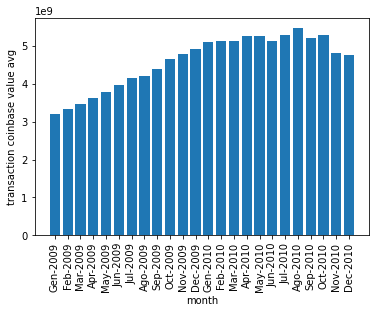

In [14]:
cs = len(blockchain) // len(months)

# list coinbase transaction ids
cb_tx_ids = set([tx["id"] for tx in txs.values() if len(list(filter(lambda x: x["output_id"] == -1, tx["in"]))) > 0])
# list of output ids of coinbase transactions
cb_out_ids = set([o["id"] for o in outputs.values() if o["tx_id"] in cb_tx_ids])

sum_tx_value = [sum([
    sum(list(map(lambda x:x["value"], tx["out"])))
    for tx in block 
    if len(list(filter(lambda i: i["output_id"] in cb_out_ids, tx["in"]))) > 0
  ]) for block in blockchain.values()]

c_sum_tx_value = []
for i in range(len(months)):
  blocks_one_month = sum_tx_value[i*cs:(i+cs)*cs-1]
  average = sum(blocks_one_month) / len(blocks_one_month)
  c_sum_tx_value.append(average)

plt.bar(months, c_sum_tx_value, align='center')
plt.xlabel('month')
plt.ylabel('transaction coinbase value avg')
plt.xticks(rotation='vertical')
plt.show()

3 - Here the sum of each transaction fee inside blocks are taken. These values, corresponding to each block, are ditributed in months and for each group of values in a single month is computed the average

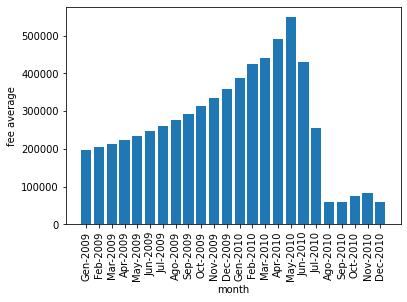

In [15]:
cs = len(blockchain) // len(months)
sum_tx_value = [
        sum([
             tx["fee"] 
             for tx in block 
             if len(list(filter(lambda x: x["output_id"] == -1, tx["in"]))) == 0
        ]) for block in blockchain.values()]

c_sum_tx_value = []
for i in range(len(months)):
  blocks_one_month = sum_tx_value[i*cs:(i+cs)*cs-1]
  average = sum(blocks_one_month) / len(blocks_one_month)
  c_sum_tx_value.append(average)

plt.bar(months, c_sum_tx_value, align='center')
plt.xlabel('month')
plt.ylabel('fee average')
plt.xticks(rotation='vertical')
plt.show()

### 5) Propose one further analysis of your choice. Give a brief description of the analysis and report the results

Here there is a function useful to extract a list of transaction that are able to compose a chain of connected transactions

In [16]:
def walk_tx_chain(origin_tx, max_depth=10):
  tx_list = [origin_tx]
  i = 1
  for tx in tx_list:
    for i in tx["in"]:
      if i["output_id"] != -1:
        to_add = txs[outputs[i["output_id"]]["tx_id"]]
        if to_add not in tx_list:
          tx_list.append(to_add)
    for o in tx["out"]:
      if o["input_id"] != -1:
        to_add = txs[inputs[o["input_id"]]["tx_id"]]
        if to_add not in tx_list:
          tx_list.append(to_add)
    if len(tx_list) > max_depth:
      break
  return tx_list

With this lines of code is plotted one example of chain of transactions. In this case is searched the chain of transaction 10 and are extracted connected transactions with depth 4. The plot represents the graph of extracted transactions and the connections among them

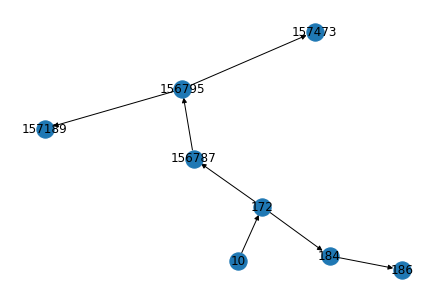

In [25]:
G = nx.DiGraph()
for tx in walk_tx_chain(txs[10], 4):
  G.add_node(tx["id"])
  for i in tx["in"]:
    if i["output_id"] != -1:
      G.add_edge(outputs[i["output_id"]]["tx_id"], tx["id"])
  for o in tx["out"]:
    if o["input_id"] != -1:
      G.add_edge(tx["id"], inputs[o["input_id"]]["tx_id"])
nx.draw(G, with_labels=True)
plt.show()

## Second Part - DHT Assessment

### Code initialization

Here there are the constants related to my node id and the max number of addresses conntained in a bucket (k)

In [18]:
my_node = "11001010"
k = 4

Function able tu create a dictionary that represents the initial state of buckets inside my hash table

In [19]:
def buckets_init():
  return {
      "11001011": [],
      "1100100": [],
      "110011": [],
      "11000": ["11000111"],
      "1101": ["11010011", "11010110"],
      "111": ["11101010", "11101110", "11100011", "11110000"],
      "10": ["10110011", "10111000", "10001000"],
      "0": ["01001111", "00110011", "01010101", "00000010"],
  }

Function to add into buckets a node and print what happen for each condition triggered

In [20]:
def add_into_buckets(node, buckets, dead_nodes=[]):
  for key, bucket in buckets.items():
    if node.startswith(key):
      print(f"\t> node {node} start with {key}")
      if node in bucket:
        print(f"\t> {node} is already in the bucket {key}")
        bucket.append(bucket.pop(bucket.index(node)))
      else:
        if len(bucket) < k:
          print(f"\t> {node} is inserted into bucket {key}")
          bucket.append(node)
        else:
          print(f"\t> bucket {key} is full")
          for i in range(4):
            n = bucket[0]
            alive = n not in dead_nodes
            print("\t\t> ping", n, "=>", "ALIVE" if alive else "DEAD")
            if not alive:
              bucket.remove(n)
              bucket.append(node)
              break
            else:
              bucket.append(bucket.pop(bucket.index(n)))

Function able to run a simulation that is an insertion of new nodes inside my hash table

In [21]:
def print_ht(buckets):
  print("----------------------------------------------------------------")
  print("HASH TABLE")
  for k, v in buckets.items():
    print(k.rjust(8, " "), ":", v)
  print("----------------------------------------------------------------")


def run_simulation(new_nodes, dead_nodes=[]):
  buckets = buckets_init()
  print_ht(buckets)
  for i, node in enumerate(new_nodes):
    print(f"{i+1}) START node:", node)
    add_into_buckets(node, buckets, dead_nodes)
    print_ht(buckets)

### 1) Messages from following nodes arrive in this given order: 01101001, 10111000, 11110001, 10101010, 11100011, 11111111 How do the buck- ets, the orderings in the buckets and the waiting lists change?

With the following code is implemented a simulator of what happen during the insertion of the new nodes. Here we have all nodes inside hash table that are active, so in case a new node should be inserted inside a full bucket this is discarded. In the other cases if a node is already inside a bucket is moved in the tail of this, instead if the bucket is not full the new node is appended to the end of bucket

In [22]:
new_nodes = ["01101001", "10111000", "11110001", "10101010", "11100011", "11111111"]

run_simulation(new_nodes)

----------------------------------------------------------------
HASH TABLE
11001011 : []
 1100100 : []
  110011 : []
   11000 : ['11000111']
    1101 : ['11010011', '11010110']
     111 : ['11101010', '11101110', '11100011', '11110000']
      10 : ['10110011', '10111000', '10001000']
       0 : ['01001111', '00110011', '01010101', '00000010']
----------------------------------------------------------------
1) START node: 01101001
	> node 01101001 start with 0
	> bucket 0 is full
		> ping 01001111 => ALIVE
		> ping 00110011 => ALIVE
		> ping 01010101 => ALIVE
		> ping 00000010 => ALIVE
----------------------------------------------------------------
HASH TABLE
11001011 : []
 1100100 : []
  110011 : []
   11000 : ['11000111']
    1101 : ['11010011', '11010110']
     111 : ['11101010', '11101110', '11100011', '11110000']
      10 : ['10110011', '10111000', '10001000']
       0 : ['01001111', '00110011', '01010101', '00000010']
-------------------------------------------------------------

### 2) Now the node detects that peer 11101110 cannot be reached anymore, what is the reaction?

Here is runned the previous simulation adding the indicated dead node. In this case if a new node is inserted inside the bucket where the dead node is and this bucket is full the dead node is discarded and the new node is appended to the end of the bucket. Each time that a node is pinged (to discover if this is still alive or not) when the reponse is positive the node is moved to the end of the bucket

In [23]:
run_simulation(new_nodes, dead_nodes=["11101110"])

----------------------------------------------------------------
HASH TABLE
11001011 : []
 1100100 : []
  110011 : []
   11000 : ['11000111']
    1101 : ['11010011', '11010110']
     111 : ['11101010', '11101110', '11100011', '11110000']
      10 : ['10110011', '10111000', '10001000']
       0 : ['01001111', '00110011', '01010101', '00000010']
----------------------------------------------------------------
1) START node: 01101001
	> node 01101001 start with 0
	> bucket 0 is full
		> ping 01001111 => ALIVE
		> ping 00110011 => ALIVE
		> ping 01010101 => ALIVE
		> ping 00000010 => ALIVE
----------------------------------------------------------------
HASH TABLE
11001011 : []
 1100100 : []
  110011 : []
   11000 : ['11000111']
    1101 : ['11010011', '11010110']
     111 : ['11101010', '11101110', '11100011', '11110000']
      10 : ['10110011', '10111000', '10001000']
       0 : ['01001111', '00110011', '01010101', '00000010']
-------------------------------------------------------------

### 3) Which addresses would the peer reply to a lookup looking for ID 11010010?

The algorithm is able to responde to the sender with the result wanted or with the addresses contained in the k-buckets near to the solution. In this case my node hasn't the value searched so it provides to the sender the list of addresses in the hash table with the same common prefix of the id of the searched resource.This code implementation is a simplifying that exploits the string prefix to search the corresponding bucket

In [24]:
id = "11010010"
buckets = buckets_init()
selected_addresses = []

for key, bucket in buckets.items():
  if id.startswith(key):
    selected_addresses = bucket
    break

print(selected_addresses)

['11010011', '11010110']
